In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import os

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.search import search
from earthtext.datamodules.components import chipmultilabel
from earthtext.osm.multilabel import OSMCodeSets
from joblib import Parallel, delayed
from importlib import reload
reload(chipmultilabel)
reload(search)

<module 'earthtext.search.search' from '/home/ubuntu/earth-text/src/earthtext/search/search.py'>

# setup

- copy `s3://clay-text/models/` into `/opt/data/models`
- copy `s3://clay-text/california-worldcover-chips` into `/opt/data/california-worldcover-chips`
- copy `s3://clay-california-worldcover-rgbnir-vvvh-chips/chips/` into `/opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips`

double check for the locations on the dataloader configuration below

    metadata_file             /opt/data/california-worldcover-chips/california-worldcover-chips-osm-multilabels.parquet
    embeddings_folder         /opt/data/california-worldcover-chips/embeddings_v0.2
    chips_folder              /opt/data/clay-california-worldcover-rgbnir-vvvh-chips/chips


    !ls /opt/data/models/osm*
    /opt/data/models/osm_emcoder_2024-04-25_12:01.ckpt
    /opt/data/models/osm_emcoder_2024-04-25_12:01.yaml

# load an initialize searcher object

- `search_target` can be `train`, `test` or `val`

In [22]:
reload(search)
model_ckpt_fname = '/opt/data/models//osm_emcoder__naip__trainedon_2024-05-17_00:57.ckpt'
model_ckpt_fname = '/opt/data/models//osm_emcoder__naip__trainedon_2024-05-24_00:57.ckpt'

searcher = search.OSMClayModelSearcher(model_ckpt_fname, search_target='train')

2024-05-24 00:59:19.621 | INFO     | earthtext.search.search:__init__:76 - search target is 'train'


In [23]:
print ("dataloader configuration\n")
for k,v in searcher.conf.dataloader.items():
    print (f"{k:25s} {v}")

dataloader configuration

_target_                  earthtext.datamodules.chipmultilabel.ChipMultilabelModule
metadata_file             /opt/data/california-naip-chips/california-naip-chips-100k.parquet
get_osm_strlabels         True
get_osm_ohearea           True
get_osm_ohecount          True
get_osm_ohelength         True
embeddings_normalization  True
multilabel_threshold_osm_ohecount 1
osmvector_normalization   True
batch_size                8
num_workers               10


In [24]:
print ("model configuration\n")
for k,v in searcher.conf.model.items():
    print (f"{k:25s} {v}")

model configuration

_target_                  earthtext.models.osmencoder.OSMEncoder
output_dim                768
layers_spec               [4096, 4096]
use_osm_counts            True
use_osm_lengths           True
use_osm_areas             True
activation_fn             relu
osm_codeset               naip


In [25]:
searcher.setup()

2024-05-24 00:59:24.230 | INFO     | earthtext.search.search:setup:115 - loading model
2024-05-24 00:59:24.439 | INFO     | earthtext.search.search:setup:119 - initializing dataloaders
2024-05-24 00:59:26.476 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:96 - using embeddings found in metadata file
2024-05-24 00:59:26.479 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - read train split with 72189 chip files (out of 72189)
2024-05-24 00:59:26.479 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:114 - max cache size is -1
2024-05-24 00:59:28.810 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:96 - using embeddings found in metadata file
2024-05-24 00:59:28.815 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - read val split with 14757 chip files (out of 14757)
2024-05-24 00:59:28.816 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:114 - max cache 

In [26]:
searcher.model.osm_codeset, searcher.model.input_dim

('naip', 357)

# build the object for autocompletion

it's ok if you get and error like `AssertionError: can only test a child process`, it seems torch dataloaders take care of it

In [27]:
autocompletion_sampler = search.QueryAutocompletionSampler(searcher=searcher, query_source='train', osm_codeset=searcher.conf.model['osm_codeset'])

2024-05-24 00:59:43.667 | INFO     | earthtext.search.search:__init__:159 - search target is train, query source is train
2024-05-24 00:59:43.669 | INFO     | earthtext.search.search:__init__:163 - loading all samples from query source
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d57e2578220>
Traceback (most recent call last):
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^Exception ignored in: Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d57e2578220>^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d57e2578220>
^
Traceback (most recent call last):
^Traceback (most recent call last):
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/

In [28]:
def get_precision_at_topn(tag_name_for_metric, n_autocomplete_samples, query_min_counts=None, query_min_area_pct=None, n_search_samples=10, max_topn=50):

    if (query_min_area_pct is not None) + (query_min_counts is not None) != 1:
        raise ValueError(f"must set exactly one of 'query_min_area_pct' and 'query_min_counts'")
    
    chipm2 = 150*150*0.6*0.6 # how many square meters in a chip
    rset = []
    precs_at_topn = []

    # make user query vector
    tag_index_for_metric = np.argwhere(searcher.model.osm_tags_names==tag_name_for_metric)[0,0]
    min_counts, max_counts = {tag_name_for_metric: query_min_counts} if query_min_counts is not None else {}, {}
    min_areas,  max_areas  = {tag_name_for_metric: query_min_area_pct*chipm2} if query_min_area_pct is not None else {}  ,{}
        
    for _ in range(n_search_samples):
        
        # average autocomplete
        q = autocompletion_sampler.sample_queries_with_conditions( min_counts = min_counts, max_counts = max_counts, 
                                               min_areas = min_areas, max_areas = max_areas,
                                               n_samples=n_autocomplete_samples)
        
        query_osmvector = {k:v.mean(axis=0).reshape(1,-1) for k,v in q['normalized_query_vector'].items()}
    
        # predict embeddings
        p = searcher.predict_embeddings(query_osmvector)[0]
        
        # search
        r = searcher.make_search(p, topn=None)
        rset.append(r)
    
        # measure precision at topn, with n = 1..max_topn
        prec_at_topn = {k: (r['original_osm_vectors']['osm_ohecount'][:, searcher.model.osm_tags_indexes][:, tag_index_for_metric][:k]>=1).mean()\
                        for k in range(1,max_topn+1)}
        precs_at_topn.append(prec_at_topn)
    return precs_at_topn
    

In [ ]:
pr = {tag_name_for_metric: get_precision_at_topn(tag_name_for_metric, n_autocomplete_samples=5, query_min_area_pct=0.3, n_search_samples=5, max_topn=50)
                                    for tag_name_for_metric in pbar(searcher.model.osm_tags_names)}

 10% (12 of 119) |##                     | Elapsed Time: 0:03:01 ETA:   0:27:01

In [ ]:
class_prec_means = {i: pd.DataFrame(pr[i]).mean(axis=1).mean() for i in pr.keys()}
class_prec_stds  = {i: pd.DataFrame(pr[i]).mean(axis=1).std() for i in pr.keys()}

Text(0, 0.5, 'precision')

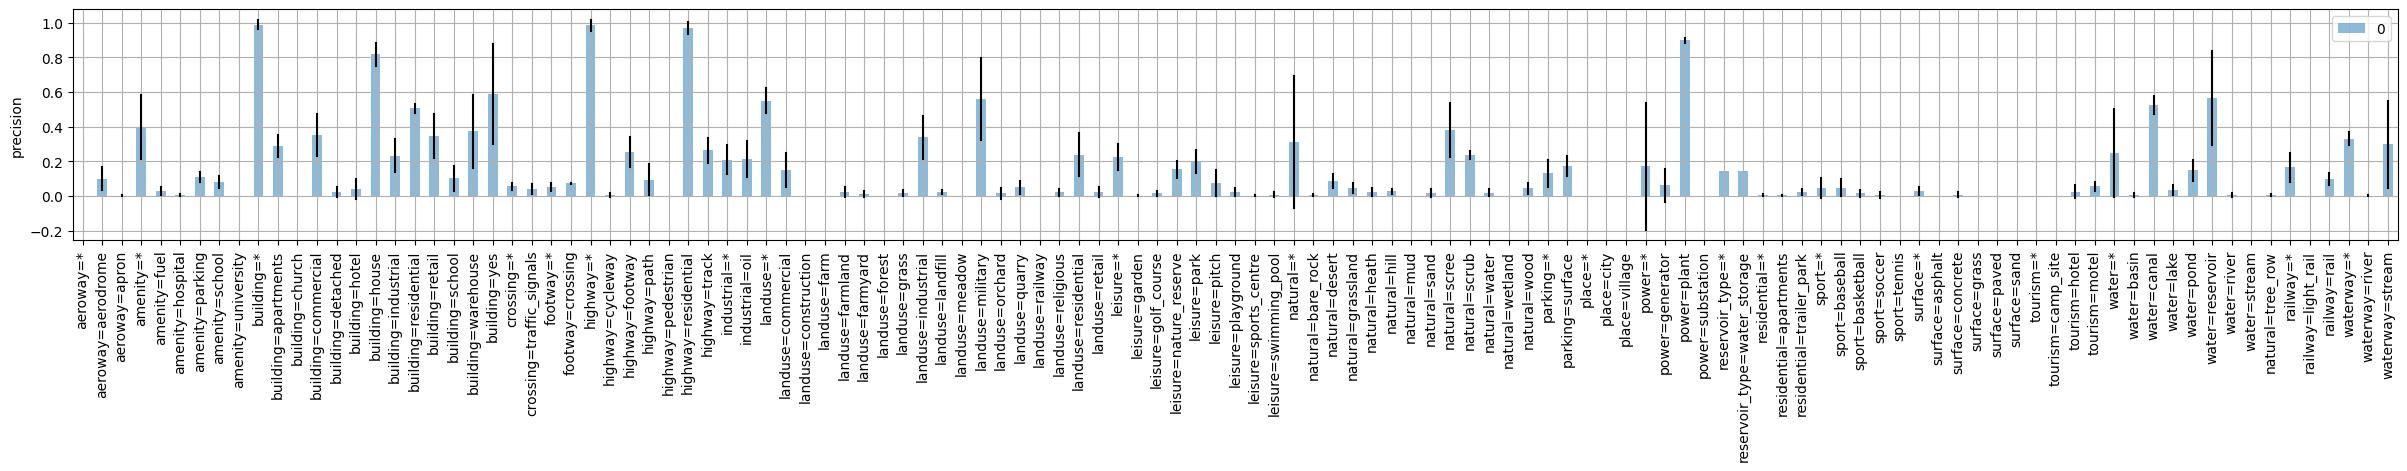

In [34]:
pdf = pd.DataFrame([class_prec_means])
pdf.T.plot(kind='bar', alpha=.5, figsize=(30,3))
for i in range(len(pdf.columns)):
    plt.plot([i,i], [class_prec_means[pdf.columns[i]] - class_prec_stds[pdf.columns[i]],
                     class_prec_means[pdf.columns[i]] + class_prec_stds[pdf.columns[i]]], color="black")
plt.grid()
plt.ylabel("precision")

In [ ]:
for ax, i in subplots(list(pr.keys()), n_cols=7):
    k = pd.DataFrame(pr[i])  
    pmeans = k.mean(axis=0).values
    pstds  = k.std(axis=0).values

    plt.plot(k.columns, pmeans, color="black")
    plt.fill_between(k.columns, pmeans-pstds, pmeans+pstds, color="gray", alpha=.5)
    plt.grid();
    plt.title(i)
    plt.ylim(0,1.1)
    plt.ylabel("precision")
    plt.xlabel("topn")